In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Import Training Data

In [2]:
choco_train = pd.read_csv("chocolate_train.csv", keep_default_na=False, index_col=0)
choco_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2224 entries, 0 to 2223
Data columns (total 36 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ref                               2224 non-null   int64  
 1   company                           2224 non-null   object 
 2   company_location                  2224 non-null   object 
 3   review_date                       2224 non-null   float64
 4   country_of_bean_origin            2224 non-null   object 
 5   specific_bean_origin_or_bar_name  2224 non-null   object 
 6   cocoa_percent                     2224 non-null   float64
 7   rating                            2224 non-null   float64
 8   counts_of_ingredients             2224 non-null   int64  
 9   taste                             2224 non-null   object 
 10  cocoa_butter                      2224 non-null   int64  
 11  vanilla                           2224 non-null   int64  
 12  lecith

# Use kfold validation

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, r2_score
from sklearn.preprocessing import StandardScaler

kfold = KFold(n_splits = 10,
              shuffle = True,
              random_state = 404)

## Choose features based on Hypothesis testing

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
choco_train.columns

Index(['ref', 'company', 'company_location', 'review_date',
       'country_of_bean_origin', 'specific_bean_origin_or_bar_name',
       'cocoa_percent', 'rating', 'counts_of_ingredients', 'taste',
       'cocoa_butter', 'vanilla', 'lecithin', 'salt', 'sugar',
       'sweetener_without_sugar', 'nutty', 'sweet', 'cocoa', 'roasty',
       'creamy', 'earthy', 'sandy', 'fatty', 'floral', 'intense', 'spicy',
       'sour', 'molasses', 'woody', 'vanilla_taste', 'sticky', 'fruit',
       'smokey', 'company_continent', 'origin_continent'],
      dtype='object')

Based on Hypothesis test's p-value, we conclude that 'cocoa_butter', 'fatty', 'sweet', 'spicy', 'intense', 'smokey', 'woody', 'roasty', 'floral' and 'sticky' are relatively less related to rating, so for feature selection, we exclude these.

Use the following features:
Numerical: 'review_date', 'cocoa_percent', 'counts_of_ingredients','company_continent', 'origin_continent',
Categorical: 'vanilla', 'salt', 'sugar', 'sweetener_without_sugar', 'lecithin', 'nutty', 'cocoa', 'creamy', 'earthy', 'sandy', 'sour', 'molasses', 'vanilla_taste', 'fruit'

#### Multi-linear Regression with kfold|

In [6]:
# Specify features
features = ['review_date', 'cocoa_percent', 'counts_of_ingredients','company_continent', 'origin_continent',
           'vanilla', 'salt', 'sugar', 'sweetener_without_sugar', 'lecithin', 'nutty', 'cocoa', 'creamy', 
            'earthy', 'sandy', 'sour', 'molasses', 'vanilla_taste', 'fruit']

In [7]:
len(features)

19

In [8]:
choco_train[features].head()

,review_date,cocoa_percent,counts_of_ingredients,company_continent,origin_continent,vanilla,salt,sugar,sweetener_without_sugar,lecithin,nutty,cocoa,creamy,earthy,sandy,sour,molasses,vanilla_taste,fruit
0,3.133333,76.0,3,3.205074,3.218661,0,0,1,0,0,0,1,0,0,0,0,0,0,1
1,3.133333,76.0,3,3.205074,3.211669,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,3.133333,76.0,3,3.205074,3.218661,0,0,1,0,0,0,1,0,0,0,0,0,0,0
3,3.206944,63.0,4,3.223531,3.224100,0,0,1,0,1,0,0,0,0,0,0,0,0,1
4,3.206944,70.0,4,3.223531,3.224100,0,0,1,0,1,1,0,0,0,0,0,0,0,0


In [9]:
# Baseline: mean of rating
print('Mean of rating in train set: ', choco_train.rating.mean() )

Mean of rating in train set:  3.198561151079137


In [10]:
## scale quantitative variables
choco_array = choco_train[features].to_numpy()

scaler = StandardScaler()

## These are the features that need to be scaled
## 'review_date', 'cocoa_percent', 'counts_of_ingredients','company_continent', 'origin_continent',
scale_columns = [0,1,2,3,4]
choco_scaled = choco_array.copy()
choco_scaled[:,scale_columns] = scaler.fit_transform(choco_scaled[:,scale_columns])

In [11]:
x = choco_scaled
y = choco_train['rating']

cv_rmses = np.zeros((10,))
cv_maes = np.zeros((10,))
cv_mes = np.zeros((10,))
cv_r2s = np.zeros((10,))

# Use mean of rating as baseline to compare
cv_rmses_baseline = np.zeros((10,))
cv_maes_baseline = np.zeros((10,))
cv_mes_baseline = np.zeros((10,))
cv_r2s_baseline = np.zeros((10,))

i = 0
for train_ind, val_ind in kfold.split(x, y):
    x_t = x[train_ind, :]
    y_t = y[train_ind]
    
    x_val = x[val_ind, :]
    y_val = y[val_ind]
    
    reg = LinearRegression(copy_X = True, fit_intercept = True)
    reg.fit(x_t, y_t)
    predicted = reg.predict(x_val)
    
    bsl = y_t.mean()*np.ones(len(y_val))
    
    cv_rmses[i] = mean_squared_error(y_val, predicted, squared=False)
    cv_maes[i] = mean_absolute_error(y_val, predicted)
    cv_mes[i] = max_error(y_val, predicted)
    cv_r2s[i] = r2_score(y_val, predicted)
    
    cv_rmses_baseline[i] = mean_squared_error(y_val, bsl, squared=False)
    cv_maes_baseline[i] = mean_absolute_error(y_val, bsl)
    cv_mes_baseline[i] = max_error(y_val, bsl)
    cv_r2s_baseline[i] = r2_score(y_val, bsl)
    
    i += 1
    

In [12]:
print('Cross Validation kfold = 10')
print('Features chosen based on hypothsis testing and using target encoding for continents')
print('Multi-linear regression with fit_intercept=True')
print()
print('RMSEs are ', cv_rmses)
print('Mean Absolute Errors are ', cv_maes)
print('Max Errors are ', cv_mes)
print('r2 scores are ', cv_r2s)

Cross Validation kfold = 10
Features chosen based on hypothsis testing and using target encoding for continents
Multi-linear regression with fit_intercept=True

RMSEs are  [0.35739474 0.37549819 0.39649015 0.38851315 0.37923487 0.37476379
 0.38068475 0.40574929 0.36163373 0.41792372]
Mean Absolute Errors are  [0.29076475 0.30105479 0.31162153 0.31220772 0.28902909 0.29778926
 0.31962526 0.33218949 0.29021906 0.32200226]
Max Errors are  [0.99301579 1.02776763 1.38066236 1.36084457 1.78497505 1.13799725
 1.05012816 1.05722101 1.36907465 1.96108261]
r2 scores are  [0.30306697 0.12997689 0.19068071 0.22631266 0.25464712 0.21350056
 0.23618098 0.18308742 0.24732899 0.13760908]


In [13]:
print('Multi-linear regression with fit_intercept=True')
print()
print('Mean of RMSEs is ', cv_rmses.mean())
print('Mean of Mean Absolute Errors is ', cv_maes.mean())
print('Mean of Max Errors is ', cv_mes.mean())
print('Mean of r2 scores is ', cv_r2s.mean())

Multi-linear regression with fit_intercept=True

Mean of RMSEs is  0.3837886364779127
Mean of Mean Absolute Errors is  0.3066503211600226
Mean of Max Errors is  1.312276907065954
Mean of r2 scores is  0.21223913853970341


In [14]:
print('Mean of baseline RMSEs is ', cv_rmses_baseline.mean())
print('Mean of baseline Mean Absolute Errors is ', cv_maes_baseline.mean())
print('Mean of baseline Max Errors is ', cv_mes_baseline.mean())
print('Mean of baseline r2 scores is ', cv_r2s_baseline.mean())

Mean of baseline RMSEs is  0.43433132470588776
Mean of baseline Mean Absolute Errors is  0.3552326361464057
Mean of baseline Max Errors is  1.4485611290258968
Mean of baseline r2 scores is  -0.007932845972848624


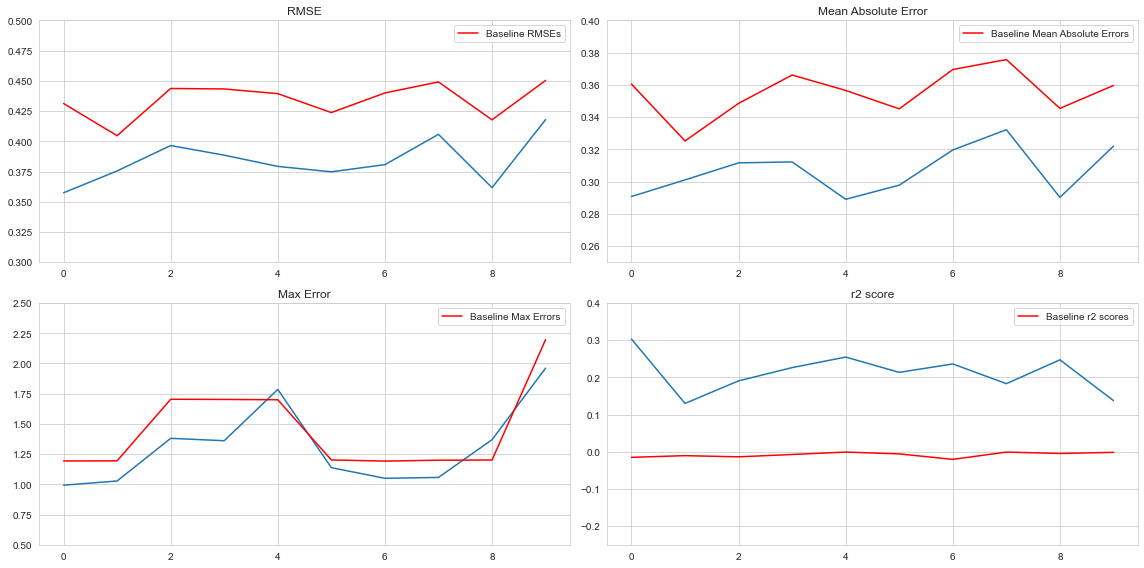

In [15]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(2, 2, figsize=(16,8))

ax[0,0].plot(cv_rmses)
ax[0,0].plot(cv_rmses_baseline, 'r-', label="Baseline RMSEs")
ax[0,0].legend()
ax[0,0].axes.set_ylim(.3, .5)
ax[0,0].title.set_text('RMSE')

ax[0,1].plot(cv_maes)
ax[0,1].plot(cv_maes_baseline, 'r-', label="Baseline Mean Absolute Errors")
ax[0,1].legend()
ax[0,1].set_ylim([.25, .4])
ax[0,1].title.set_text('Mean Absolute Error')

ax[1,0].plot(cv_mes)
ax[1,0].plot(cv_mes_baseline, 'r-', label="Baseline Max Errors")
ax[1,0].legend()
ax[1,0].set_ylim([.5,2.5])
ax[1,0].title.set_text('Max Error')

ax[1,1].plot(cv_r2s)
ax[1,1].plot(cv_r2s_baseline, 'r-', label="Baseline r2 scores")
ax[1,1].legend()
ax[1,1].set_ylim([-.25,.4])
ax[1,1].title.set_text('r2 score')


plt.tight_layout()

plt.show()

After some experiments, observed that using fit_intercept = True/False or scaling numerical variables or not does not change the errors returned at all (this example above is using fit_intercept = True with numerical data scaled)

## Choose features using Lasso Regression

In [16]:
from sklearn.linear_model import Lasso

In [17]:
# excluding company and specific_bean_origin_or_bar_name
    
features_all = ['review_date', 'cocoa_percent', 'counts_of_ingredients', 'company_continent',
               'origin_continent', 'vanilla', 'salt', 'sugar',
               'sweetener_without_sugar', 'cocoa_butter', 'lecithin', 'nutty', 'sweet', 'cocoa', 'roasty', 'creamy',
               'earthy', 'sandy', 'fatty', 'floral', 'intense', 'spicy', 'sour',
               'molasses', 'woody', 'vanilla_taste', 'sticky', 'fruit', 'smokey']

In [18]:
## scale quantitative variables
choco_array_all = choco_train[features_all].to_numpy()

scaler = StandardScaler()

## These are the features that need to be scaled
## 'review_date', 'cocoa_percent', 'counts_of_ingredients', 'company_continent', 'origin_continent'
scale_columns = [0,1,2,3,4]
choco_scaled_all = choco_array_all.copy()
choco_scaled_all[:,scale_columns] = scaler.fit_transform(choco_scaled_all[:,scale_columns])

In [19]:
alphas = [.000001,.00001,.0001] + list(np.linspace(.001, .01, num=40)) + list(np.linspace(0.011, 0.05, num=40))

## make coefficient holder
coefs = np.zeros((len(alphas), len(features_all)))


## Loop through alphas
for i in range(len(alphas)):
    ## make lasso model
    lasso = Lasso(alpha=alphas[i], max_iter=10000000)
    
    ## fit model
    lasso.fit(choco_scaled_all, choco_train['rating'])
    
    ## record coefs
    coefs[i,:] = lasso.coef_

In [20]:
## use dataframe to look at coefs
lasso_df = pd.DataFrame(coefs, index=alphas, columns=features_all)

In [21]:
pd.set_option('display.max_rows', None)
lasso_df

,review_date,cocoa_percent,counts_of_ingredients,company_continent,origin_continent,vanilla,salt,sugar,sweetener_without_sugar,cocoa_butter,...,floral,intense,spicy,sour,molasses,woody,vanilla_taste,sticky,fruit,smokey
0.000001,0.053092,-0.039875,-0.028671,0.021733,0.016417,-0.094665,-0.048054,0.137555,-0.058200,0.072137,...,0.056993,0.049471,0.085803,-0.146676,-0.155918,-0.035845,-0.245934,0.000128,0.199148,0.020372
0.000010,0.053081,-0.039857,-0.028666,0.021728,0.016414,-0.094631,-0.047596,0.137703,-0.057928,0.072064,...,0.056831,0.049406,0.085714,-0.146583,-0.155707,-0.035611,-0.245747,0.000000,0.199112,0.020185
0.000100,0.052977,-0.039690,-0.028528,0.021684,0.016401,-0.094401,-0.043082,0.138246,-0.056133,0.071255,...,0.055231,0.048770,0.084852,-0.145609,-0.153557,-0.033262,-0.243878,0.000000,0.198765,0.018291
0.001000,0.051943,-0.038146,-0.026932,0.021231,0.016272,-0.092294,-0.000000,0.139854,-0.041034,0.063164,...,0.039866,0.042434,0.076344,-0.135487,-0.131545,-0.009948,-0.224923,-0.000000,0.195782,0.000000
0.001231,0.051768,-0.037730,-0.025705,0.021096,0.016221,-0.092928,-0.000000,0.139869,-0.034465,0.060345,...,0.036119,0.040659,0.074458,-0.132855,-0.125624,-0.003821,-0.219322,-0.000000,0.195048,0.000000
0.001462,0.051589,-0.037323,-0.024503,0.020968,0.016161,-0.093530,-0.000000,0.139976,-0.027852,0.057554,...,0.032291,0.038800,0.072540,-0.130300,-0.119788,-0.000000,-0.213811,-0.000000,0.194240,0.000000
0.001692,0.051401,-0.036931,-0.023341,0.020853,0.016087,-0.094078,-0.000000,0.140258,-0.021146,0.054812,...,0.028329,0.036799,0.070568,-0.127871,-0.114093,-0.000000,-0.208447,-0.000000,0.193310,0.000000
0.001923,0.051212,-0.036539,-0.022180,0.020737,0.016012,-0.094626,-0.000000,0.140558,-0.014422,0.052070,...,0.024367,0.034799,0.068596,-0.125441,-0.108397,-0.000000,-0.203083,-0.000000,0.192379,0.000000
0.002154,0.051024,-0.036147,-0.021018,0.020621,0.015938,-0.095174,-0.000000,0.140839,-0.007717,0.049328,...,0.020406,0.032798,0.066624,-0.123012,-0.102702,-0.000000,-0.197719,-0.000000,0.191449,0.000000
0.002385,0.050836,-0.035755,-0.019861,0.020506,0.015863,-0.095717,-0.000000,0.141134,-0.000997,0.046592,...,0.016444,0.030797,0.064651,-0.120583,-0.097007,-0.000000,-0.192354,-0.000000,0.190519,0.000000


In [22]:
feature_lists = []

for index, row in lasso_df.iterrows():
    l = list(lasso_df.columns[lasso_df.loc[index].to_numpy().nonzero()])
    feature_lists.append(l)
    
    print('For alpha ', index)
    print('Features are:')
    print(l)
    print('Number: ', len(l))
    print()

For alpha  1e-06
Features are:
['review_date', 'cocoa_percent', 'counts_of_ingredients', 'company_continent', 'origin_continent', 'vanilla', 'salt', 'sugar', 'sweetener_without_sugar', 'cocoa_butter', 'nutty', 'sweet', 'cocoa', 'roasty', 'creamy', 'earthy', 'sandy', 'fatty', 'floral', 'intense', 'spicy', 'sour', 'molasses', 'woody', 'vanilla_taste', 'sticky', 'fruit', 'smokey']
Number:  28

For alpha  1e-05
Features are:
['review_date', 'cocoa_percent', 'counts_of_ingredients', 'company_continent', 'origin_continent', 'vanilla', 'salt', 'sugar', 'sweetener_without_sugar', 'cocoa_butter', 'nutty', 'sweet', 'cocoa', 'roasty', 'creamy', 'earthy', 'sandy', 'fatty', 'floral', 'intense', 'spicy', 'sour', 'molasses', 'woody', 'vanilla_taste', 'fruit', 'smokey']
Number:  27

For alpha  0.0001
Features are:
['review_date', 'cocoa_percent', 'counts_of_ingredients', 'company_continent', 'origin_continent', 'vanilla', 'salt', 'sugar', 'sweetener_without_sugar', 'cocoa_butter', 'nutty', 'sweet', 'c

In [23]:
len(lasso_df.columns)

29

In [24]:
# Make list of models based on lasso_df
num = set()
models = list()

for selection in feature_lists:
    if len(selection) != 0 and len(selection) not in num:
        num.add(len(selection))
        models.append(selection)

In [25]:
len(models)

21

In [26]:
cv_rmses_mul = np.zeros((10, len(models)))
cv_maes_mul = np.zeros((10, len(models)))
cv_mes_mul = np.zeros((10, len(models)))
cv_r2s_mul = np.zeros((10, len(models)))

i = 0
for train_ind, val_ind in kfold.split(choco_train):
    x_t = choco_train.iloc[train_ind]
    
    x_val = choco_train.iloc[val_ind]
    
    j = 0
    for model in models:
        reg = LinearRegression(copy_X = True)
        reg.fit(x_t[model], x_t['rating'])
        cv_rmses_mul[i,j] = mean_squared_error(x_val['rating'], reg.predict(x_val[model]), squared = False)
        cv_maes_mul[i,j] = mean_absolute_error(x_val['rating'], reg.predict(x_val[model]))
        cv_mes_mul[i,j] = max_error(x_val['rating'], reg.predict(x_val[model]))
        cv_r2s_mul[i,j] = r2_score(x_val['rating'], reg.predict(x_val[model]))
        
        j = j + 1
    i = i + 1

In [27]:
# Look at MAE
model_fin = models[np.argmin(np.mean(cv_maes_mul, axis=0))]
print('Model with the least mean MAE is ', model_fin)

Model with the least mean MAE is  ['review_date', 'cocoa_percent', 'counts_of_ingredients', 'company_continent', 'origin_continent', 'vanilla', 'sugar', 'sweetener_without_sugar', 'cocoa_butter', 'nutty', 'sweet', 'cocoa', 'creamy', 'earthy', 'sandy', 'fatty', 'floral', 'intense', 'spicy', 'sour', 'molasses', 'woody', 'vanilla_taste', 'fruit']


In [28]:
len(model_fin)

24

In [29]:
min(np.mean(cv_maes_mul, axis=0))

0.30375869464010696

This is slightly better than the model using features selected based on hypothesis tests (i.e. 0.3066503211600226)

Baseline mean MAE is 0.3552326361464057.

### Feature Importance based on Final Model

In [30]:
# Look at pearson correlation coefficient

np.abs(choco_train[['rating', 'review_date', 'cocoa_percent', 'counts_of_ingredients', 'company_continent', 
                      'origin_continent', 'vanilla', 'sugar', 'sweetener_without_sugar', 'cocoa_butter', 'nutty', 
                      'sweet', 'cocoa', 'creamy', 'earthy', 'sandy', 'fatty', 'floral', 'intense', 'spicy', 
                      'sour', 'molasses', 'woody', 'vanilla_taste', 'fruit']].corr()['rating']).sort_values(
                        ascending = False)


rating                     1.000000
fruit                      0.220861
creamy                     0.192097
cocoa                      0.173751
vanilla_taste              0.167475
vanilla                    0.164881
sandy                      0.155594
review_date                0.152766
sour                       0.113028
earthy                     0.109128
nutty                      0.105403
molasses                   0.096027
counts_of_ingredients      0.094850
sugar                      0.092216
sweetener_without_sugar    0.087438
cocoa_percent              0.078508
origin_continent           0.072498
company_continent          0.072474
fatty                      0.066821
sweet                      0.065757
spicy                      0.053623
intense                    0.048309
woody                      0.019224
cocoa_butter               0.012224
floral                     0.005290
Name: rating, dtype: float64

Higher value means more linearly correlated to rating.

# Fit Test Data

In [31]:
choco_test = pd.read_csv("chocolate_test.csv", keep_default_na=False, index_col=0)

In [36]:
reg_fin = LinearRegression(copy_X = True)
reg_fin.fit(choco_train[model_fin], choco_train['rating'])
mae = mean_absolute_error(choco_test['rating'], reg.predict(choco_test[model]))

In [37]:
print('MAE on test set is ', mae)

MAE on test set is  0.27294296649293226
